In [2]:
import numpy as np
import json
import cv2
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mean

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn.functional import threshold, normalize
import monai

from transformers import SamProcessor
from transformers import SamModel 

from mask_converter import get_mask_coco, get_mask_vgg




### __UTILITIES__

In [3]:
def create_and_save(json_path = 'dataset_labels.json', 
                    img_folder='dataset_cropped', 
                    target_resize=(256, 256), 
                    save_path='dataset.npy', 
                    json_type='coco'):

    if json_type == 'coco':
        get_mask = get_mask_coco

        with open(json_path, 'r') as f:
            my_labels = json.load(f)

        data_length = len(my_labels['images'])

    elif json_type == 'vgg':
        get_mask = get_mask_vgg

        with open(json_path, 'r') as f:
            my_labels = json.load(f)

        data_length = len(my_labels)

    print(f"Found total {data_length} annotated images.")

    dataset={}

    for idx in tqdm(range(data_length)):
        item = {}

        try:
            mask2d, img_path = get_mask(idx, my_labels, img_folder)
        except:
            break

        image = cv2.imread(img_path)

        # Resize image and mask to [256, 256, 3] and [256, 256] respectively
        image = cv2.resize(image, target_resize)
        mask2d = cv2.resize(mask2d, target_resize)

        item['image'] = image
        item['label'] = mask2d

        dataset[idx] = item

    np.save(save_path, dataset)

    return dataset

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def display_dataset(idxs, dataset):
    # get square root of len(idxs)
    n = int(np.ceil(np.sqrt(len(idxs))))
    fig, axes = plt.subplots(n, n)

    for i, idx in enumerate(idxs):
        ax = axes[i//n, i%n]
        ax.imshow(dataset[idx]['image'])
        show_mask(dataset[idx]['label'], ax)
        ax.axis('off')

def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

def load_model(model_cp):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    # model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

    # load model from checkpoint EW_model_100.pt
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
    model.load_state_dict(torch.load(model_cp))

    return processor, model



### __MAKE DATASET__

In [4]:
# create_and_save(json_path='vgg_label.json',
#                 save_path='new_dataset.npy',
#                 json_type='vgg')

### __LOAD DATASET__

In [5]:
dataset = np.load('new_dataset.npy', allow_pickle=True).item()

dataset


{0: {'image': array([[[153, 153, 153],
          [147, 147, 147],
          [138, 138, 138],
          ...,
          [170, 170, 170],
          [166, 166, 166],
          [165, 165, 165]],
  
         [[152, 152, 152],
          [148, 148, 148],
          [139, 139, 139],
          ...,
          [166, 166, 166],
          [165, 165, 165],
          [163, 163, 163]],
  
         [[150, 150, 150],
          [148, 148, 148],
          [139, 139, 139],
          ...,
          [167, 167, 167],
          [165, 165, 165],
          [163, 163, 163]],
  
         ...,
  
         [[114, 114, 114],
          [110, 110, 110],
          [110, 110, 110],
          ...,
          [153, 153, 153],
          [152, 152, 152],
          [153, 153, 153]],
  
         [[128, 128, 128],
          [127, 127, 127],
          [127, 127, 127],
          ...,
          [156, 156, 156],
          [155, 155, 155],
          [154, 154, 154]],
  
         [[131, 131, 131],
          [136, 136, 136],
          [1

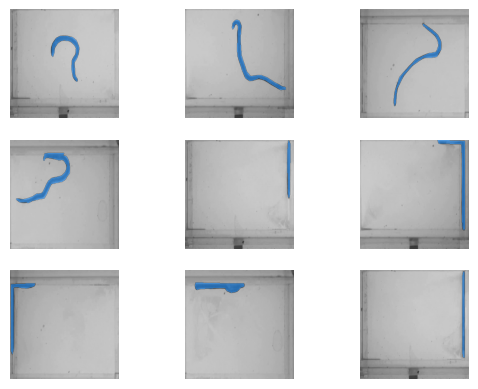

In [6]:
display_dataset([0, 1, 2, 3, 4, 5, 6, 7, 8], dataset)

In [7]:

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = item["label"]

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [8]:

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [9]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [10]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)



### __Create PyTorch DataLoader__
Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [13]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### __Load the Model__

In [14]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

### __Train the model__

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

def trainer(model, 
            train_dataloader,
            epochs,
            model_name):
  
  # Note: Hyperparameter tuning could improve performance here
  optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

  seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
  
  num_epochs = epochs

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  print(f"Using device: {device}")


  print("Starting training...")
  training_process = {}
  model.train()
  for epoch in range(num_epochs):
      epoch_losses = []
      for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

      print(f'EPOCH: {epoch}')
      print(f'Mean loss: {mean(epoch_losses)}')

      training_process[epoch] = mean(epoch_losses)

  torch.save(model.state_dict(), model_name)

  return model, training_process



In [17]:
#model, training_process = trainer(model=model,
                                    train_dataloader=train_dataloader,
                                    epochs=200,
                                    model_name='EW_model_200.pt')

IndentationError: unexpected indent (2175623298.py, line 2)

### __INFERENCE ON TRAINING DATASET__

#### Load dataset and take a look at ground truth mask

In [18]:
dataset = np.load('new_dataset.npy', allow_pickle=True).item()

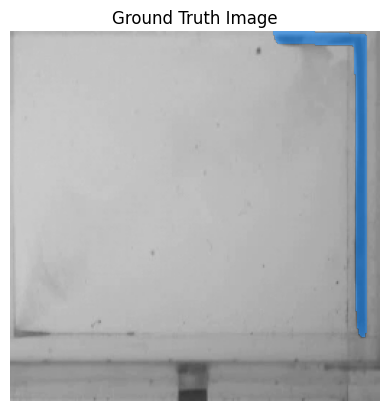

In [19]:
# let's take a random training example
idx = 5
fig, axes = plt.subplots()

# load image
image = dataset[idx]["image"]
ground_truth_mask = dataset[idx]["label"]
# show image on 2 axes
axes.imshow(image)
show_mask(ground_truth_mask, axes)
axes.axis("off")
axes.title.set_text(f"Ground Truth Image")



#### LOAD CUSTOM MODEL


In [20]:
# Load processor & custom model checkpoint
processor, model = load_model('EW_model_200.pt')

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[prompt], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


#### Validation Set Prediction - For Confirmation

In [21]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [22]:

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

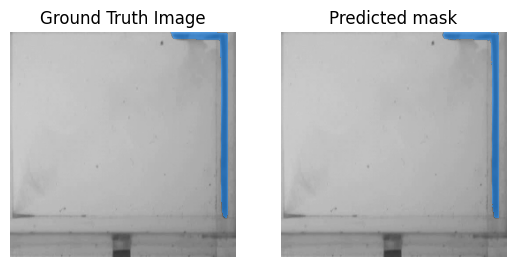

In [23]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots(1, 2)

# show image on 2 axes
axes[0].imshow(image)
show_mask(ground_truth_mask, axes[0])
axes[0].axis("off")
axes[0].title.set_text(f"Ground Truth Image")

axes[1].imshow(np.array(image))
show_mask(medsam_seg, axes[1])
axes[1].title.set_text(f"Predicted mask")
axes[1].axis("off")

### __INFERENCE ON TEST IMAGE__

#### INFERENCE UTILITIES

In [24]:
import cv2

def convert_to_relative(absolute, img_shape):
    # convert coordinates to relative bounding box
    H, W, _ = img_shape
    x = absolute[0] / W
    y = absolute[1] / H
    w = absolute[2] / W
    h = absolute[3] / H

    return [x, y, w, h]

def convert_to_absolute(relative, img_shape):
    # convert coordinates to absolute bounding box
    H, W, _ = img_shape
    x = int(relative[0] * W)
    y = int(relative[1] * H)
    w = int(relative[2] * W)
    h = int(relative[3] * H)

    return [x, y, w, h]

def convert_to_xyxy(absolute_xywh):
    # convert absolute bounding box to xyxy format
    x1 = absolute_xywh[0]
    y1 = absolute_xywh[1]
    x2 = absolute_xywh[0] + absolute_xywh[2]
    y2 = absolute_xywh[1] + absolute_xywh[3]

    return [x1, y1, x2, y2]


def labeler(image_path):
    # select ROI

    img = cv2.imread(image_path)

    r = cv2.selectROI(img)

    # print out selected coordinates
    print(f"Selected coordinates: {r}")
    print("x coordinate: ", r[0])
    print("y coordinate: ", r[1])
    print("width: ", r[2])
    print("height: ", r[3])

    # change to relative
    relative = convert_to_relative(r, img.shape)

    pressed_key = cv2.waitKey(0)
    if pressed_key == ord('q'):
        cv2.destroyAllWindows()
        return relative


In [25]:
def main_program():
    pass

In [26]:
cv2.destroyAllWindows()

#### INFERENCE STEP BY STEP

In [27]:
processor, model = load_model('EW_model_200.pt')

In [28]:
image_path = r"dataset_cropped\2\frame2375_BL.jpg"
relative_coords = labeler(image_path)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [ ]:
relative_coords

NameError: name 'relative_coords' is not defined

In [ ]:
# load from test image
image = Image.open(image_path)
image = np.array(image)
target_resize=(256, 256)
height, width, channels = image.shape
print("Image size (width x height):", width, "x", height)

image = cv2.resize(image, target_resize)
prompt = convert_to_absolute(relative_coords, image.shape)
image.shape
prompt

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_cropped\\2\\frame2375_BL.jpg'

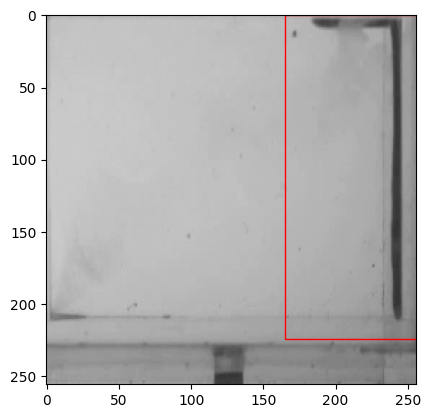

In [ ]:
fig, axes = plt.subplots()

# draw bounding box
x_min, y_min, w, h = prompt
rect = plt.Rectangle((x_min, y_min), w, h, fill=False, color='r')
axes.add_patch(rect)
axes.imshow(np.array(image))


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


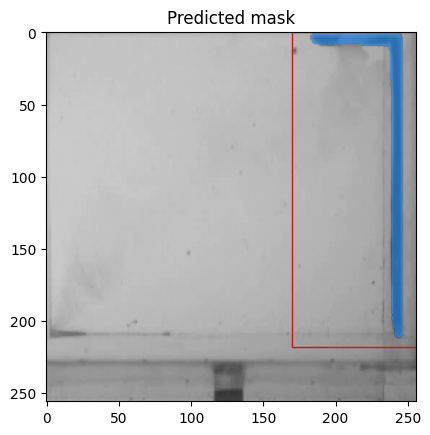

In [ ]:
# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[prompt], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)
  
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

def draw_box(prompt, ax):
    x_min, y_min, w, h = prompt
    rect = plt.Rectangle((x_min, y_min), w, h, fill=False, color='r')
    ax.add_patch(rect)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
draw_box(prompt, axes)
axes.title.set_text(f"Predicted mask")

In [ ]:
medsam_seg[45]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

#### INFERENCER ALL-IN-ONE

In [44]:

def inferencer(image_path, processor, model):
    relative_coords = labeler(image_path)

    image = Image.open(image_path)
    image = np.array(image)
    target_resize=(256, 256)
    height, width, channels = image.shape
    print("Image size (width x height):", width, "x", height)

    image = cv2.resize(image, target_resize)
    box = convert_to_absolute(relative_coords, image.shape)
    prompt = convert_to_xyxy(box)

    print("BBOX xywh", box)
    print("BBOX xyxy", prompt)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[prompt], return_tensors="pt").to(device)
    for k,v in inputs.items():
        print(k,v.shape)
    
    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    def draw_box(box, ax):
        x_min, y_min, w, h = box
        rect = plt.Rectangle((x_min, y_min), w, h, fill=False, color='r')
        ax.add_patch(rect)

    fig, axes = plt.subplots(1,2)

    # draw bounding box
    x_min, y_min, w, h = box
    rect = plt.Rectangle((x_min, y_min), w, h, fill=False, color='r')
    axes[0].add_patch(rect)
    axes[0].imshow(np.array(image))

    axes[1].imshow(np.array(image))
    show_mask(medsam_seg, axes[1])
    draw_box(box, axes[1])
    axes[1].title.set_text(f"Predicted mask")

    return medsam_seg
    

In [45]:
processor, model = load_model('EW_model_200.pt')


In [46]:
# cv2.destroyAllWindows()

Selected coordinates: (161, 231, 343, 103)
x coordinate:  161
y coordinate:  231
width:  343
height:  103
Image size (width x height): 512 x 384
BBOX xywh [80, 154, 171, 68]
BBOX xyxy [80, 154, 251, 222]
pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
Normalized polygon coordinates in YOLO dataset format have been saved to E:\Amir\EWTracker\segmented_txt_files\frame3077_BL.txt.
Selected coordinates: (0, 0, 0, 0)
x coordinate:  0
y coordinate:  0
width:  0
height:  0
Image size (width x height): 512 x 384


TypeError: 'NoneType' object is not subscriptable

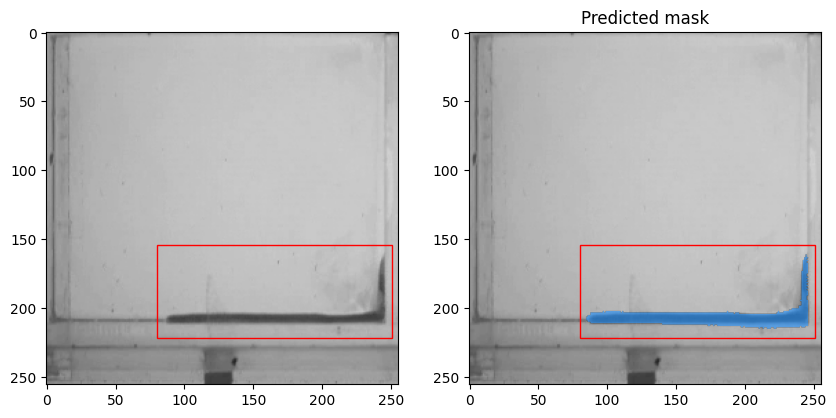

: 

In [48]:
image_folder = r"dataset_cropped\2"
# get me a random image from image_folder
import random
import os
import cv2
import numpy as np

#image_path = os.path.join(image_folder, random.choice(os.listdir(image_folder)))
#image_file = random.choice(os.listdir(image_folder))
#image_path = os.path.join(image_folder, image_file)

#this is for to not repeat image file by random function
image_files = os.listdir(image_folder)

selected_images = []

while image_files:
    # Get a random image file from the remaining files
    image_file = random.choice(image_files)
    image_path = os.path.join(image_folder, image_file)


    # Call the inferencer function with the randomly selected image
    medsam_ex = inferencer(image_path, processor, model)
    medsam_ex = np.array(medsam_seg) # convert medsam_ex to a numpy array

    # Extract the file name (without extension) from the randomly selected image
    image_name = os.path.splitext(image_file)[0]

    # PRESS ENTER AFTER SELECTING ROI AND THEN PRESS 'Q' TO QUIT




    # Step 1: Image Segmentation
    # Perform image segmentation using a suitable algorithm and obtain the binary mask
    # Let's assume 'segmented_image' is the binary mask obtained after segmentation

    # Step 2: Find the contour
    contours, _ = cv2.findContours(medsam_ex, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Get polygon coordinates and normalize
    polygon_coordinates = []
    for contour in contours:
        contour_coordinates = contour.squeeze().tolist()  # Convert contour to a list of (x, y) coordinates
        polygon_coordinates.append(contour_coordinates)

    # Normalize polygon coordinates
    normalized_polygon_coordinates = []
    for coordinates in polygon_coordinates:
        normalized_coordinates = []
        for coord in coordinates:
            normalized_coord = [float(coord[0]) / medsam_seg_prob.shape[1], float(coord[1]) / medsam_seg_prob.shape[0]]
            normalized_coordinates.append(normalized_coord)
        normalized_polygon_coordinates.append(normalized_coordinates)

    # Save normalized polygon coordinates in YOLO dataset format
    output_directory = r"E:\Amir\EWTracker\segmented_txt_files"
    output_file_name = os.path.join(output_directory, image_name + ".txt") 
    with open(output_file_name, 'w') as file:
        for i, coordinates in enumerate(normalized_polygon_coordinates):
            class_index = 0  # Class index (assuming 0 for all objects)
            line = f"{class_index} {' '.join([f'{coord[0]:.4f} {coord[1]:.4f}' for coord in coordinates])}"
            file.write(line)
            file.write('\n')

    print(f"Normalized polygon coordinates in YOLO dataset format have been saved to {output_file_name}.")

    # Remove the selected image from the list of remaining files
    image_files.remove(image_file)

    # Add the selected image to the list of selected images
    selected_images.append(image_file)

    # Check if all images have been processed
    if len(selected_images) == len(os.listdir(image_folder)):
        print("All images have been processed.")
        break



In [32]:
import random
import os

# Set the image folder path
image_folder = r"dataset_cropped\2"

# Get the list of image files in the folder
image_files = os.listdir(image_folder)

# Initialize an empty list to keep track of selected images
selected_images = []

# Iterate until all images have been processed
while image_files:
    # Get a random image file from the remaining files
    image_file = random.choice(image_files)
    image_path = os.path.join(image_folder, image_file)

    # Call the inferencer function with the randomly selected image
    medsam_ex = inferencer(image_path, processor, model)

    # Extract the file name (without extension) from the randomly selected image
    image_name = os.path.splitext(image_file)[0]

    # Save the normalized polygon coordinates in a text file with the same name as the image
    output_file_name = image_name + ".txt"
    with open(output_file_name, 'w') as file:
        for i, coordinates in enumerate(medsam_ex['normalized_polygon_coordinates']):
            class_index = 0  # Class index (assuming 0 for all objects)
            line = f"{class_index} {' '.join([f'{coord[0]:.4f} {coord[1]:.4f}' for coord in coordinates])}"
            file.write(line)
            file.write('\n')

    print(f"Normalized polygon coordinates for {image_file} have been saved to {output_file_name}.")

    # Remove the selected image from the list of remaining files
    image_files.remove(image_file)

    # Add the selected image to the list of selected images
    selected_images.append(image_file)

    # Check if all images have been processed
    if len(selected_images) == len(os.listdir(image_folder)):
        print("All images have been processed.")
        break


NameError: name 'inferencer' is not defined

In [33]:
#plt medsam_ex
plt.imshow(medsam_ex)
#type of medsam_ex
medsam_ex

NameError: name 'medsam_ex' is not defined

In [34]:
medsam_ex[48]

NameError: name 'medsam_ex' is not defined

In [35]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np


def convert_to_coords(input_mask):
    mask_rows = input_mask.shape[0] 
    mask_columns = input_mask.shape[1]

    coords = []

    for row in range(mask_rows):
        for column in range(mask_columns):
            if input_mask[row][column] == 1:
                coords.append([row, column])

    return coords

coords = convert_to_coords(medsam_ex)
hull = ConvexHull(coords)

NameError: name 'medsam_ex' is not defined

In [36]:
rng = np.random.default_rng()
points = rng.random((30, 2))

points

array([[0.1847893 , 0.63923398],
       [0.33137615, 0.87771749],
       [0.85280547, 0.0106279 ],
       [0.54393826, 0.94243807],
       [0.91459877, 0.14402202],
       [0.40660273, 0.77396967],
       [0.70958664, 0.33203977],
       [0.67826234, 0.27376769],
       [0.17083536, 0.65901057],
       [0.12692001, 0.72685371],
       [0.43986864, 0.89246833],
       [0.73200233, 0.81641916],
       [0.26673238, 0.54741622],
       [0.36760156, 0.69009104],
       [0.27412729, 0.46842101],
       [0.9268863 , 0.16462191],
       [0.77226964, 0.66738683],
       [0.48047196, 0.1292127 ],
       [0.59231109, 0.58584412],
       [0.03508461, 0.35041396],
       [0.01060599, 0.68522473],
       [0.1177001 , 0.32333193],
       [0.84454567, 0.54075103],
       [0.54930112, 0.02971575],
       [0.61635969, 0.69785781],
       [0.80908861, 0.95261528],
       [0.98270028, 0.58620837],
       [0.65013156, 0.20008549],
       [0.39138286, 0.75742683],
       [0.98596487, 0.170795  ]])

In [37]:
coords_np = np.array(coords)
coords_np

NameError: name 'coords' is not defined

In [38]:
import matplotlib.pyplot as plt
plt.plot(coords_np[:,0], coords_np[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(coords_np[simplex, 0], coords_np[simplex, 1], 'k-')

plt.plot(coords_np[hull.vertices,0], coords_np[hull.vertices,1], 'r--', lw=2)
plt.plot(coords_np[hull.vertices[0],0], coords_np[hull.vertices[0],1], 'ro')
plt.show()

NameError: name 'coords_np' is not defined

Image size (width x height): 512 x 384


NameError: name 'yolo_polygons' is not defined

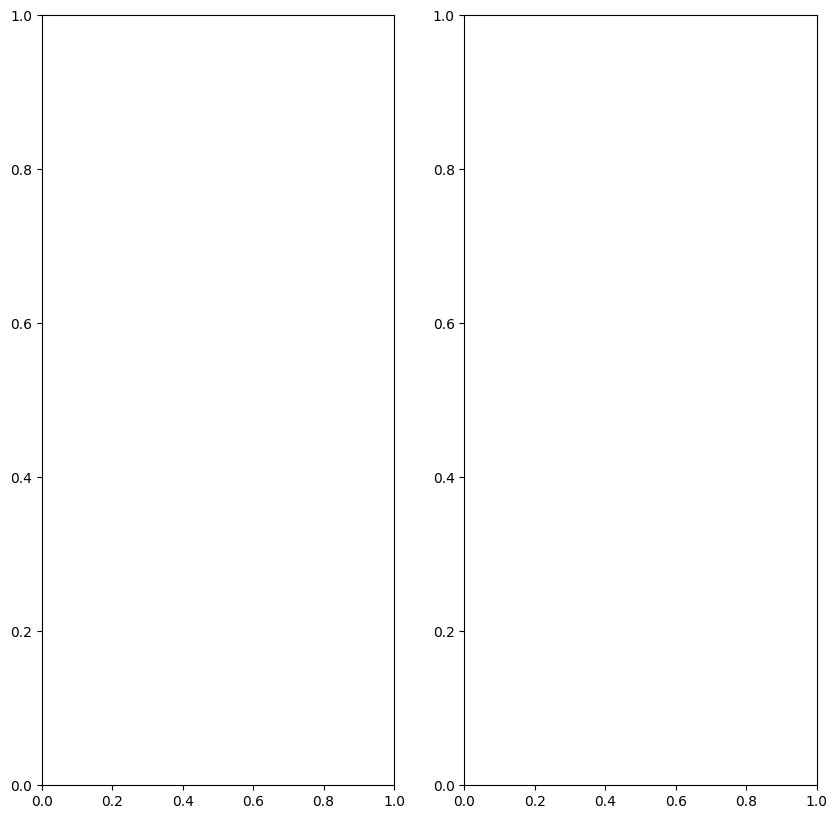

In [39]:


def convert_to_polygon(input_mask):

    mask_rows = input_mask.shape[0] 
    mask_columns = input_mask.shape[1]

    polygons = []
    highest_col_first_row = -1
    top_image_row = -1

    # iterate through the mask to find the first point
    for row in range(mask_rows):
        for column in range(mask_columns):
            if input_mask[row][column] == 1:
                polygons.append([row, column])
                highest_col_first_row = column
                top_image_row = row
        if highest_col_first_row != -1 and top_image_row != -1:
            break
    print("Top right point", highest_col_first_row)


    bottom_right_point = [-1, -1]
    print(f"Searching for right border from row {top_image_row+1} to {mask_rows}")
    for row in range(top_image_row+1, mask_rows):
        #iterate in reverse of range(mask_columns)
        found = False
        for column in range(0, highest_col_first_row-1, -1):
            if input_mask[row][column] == 1:
                bottom_right_point = [row, column]
                polygons.append(bottom_right_point)
                found = True
                break
        if found == False:
            break

    print("Bottom right point", bottom_right_point)

    bottom_left_point = [-1, -1]
    print(f"Searching for bottom left point in row {bottom_right_point[0]}")
    print(f"From column {bottom_right_point[1]} to 0")
    for column in range(0, bottom_right_point[1], -1):
        if input_mask[bottom_right_point[0]][column] == 1:
            bottom_left_point = [bottom_right_point[0], column]
            polygons.append(bottom_left_point)
        else:
            break

    print("Bottom left point", bottom_left_point)

    print("Searching for left border in rows: ", top_image_row, "to", bottom_left_point[0]-1)
    for row in range(top_image_row, bottom_left_point[0]-1, -1):
        for column in range(0, mask_columns):
            if input_mask[row][column] == 1:
                polygons.append([row, column])
                break

    return polygons




# draw the polygons on the image
def draw_polygon(polygons, ax):
    for [x, y] in polygons:
        ax.scatter(y, x, color='r', s=1)


image = Image.open(image_path)
image = np.array(image)
target_resize=(256, 256)
height, width, channels = image.shape
print("Image size (width x height):", width, "x", height)

image = cv2.resize(image, target_resize)

# set fig size
plt.rcParams["figure.figsize"] = (10,10)

fig, axes = plt.subplots(1,2)

draw_polygon(yolo_polygons, axes[0])
axes[0].imshow(np.array(image))

axes[1].imshow(np.array(image))
show_mask(medsam_ex, axes[1])
axes[1].title.set_text(f"Predicted mask")

